<a href="https://colab.research.google.com/github/turab45/Audd-multi-modality-for-urdu-audio/blob/master/multi-dodality%20on%20gujrati%20digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import cv2
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/Nikunj1729/free-spoken-gujarati-digit-dataset

In [ ]:
cd free-spoken-gujarati-digit-dataset/

In [ ]:
# Feature extraction methods

def CalculateZeroCrossingRate(file_location):
    y, sr = librosa.load(file_location)
    zCross = librosa.feature.zero_crossing_rate(y=y)
    dim = (32, 32)
    resized = cv2.resize(zCross, dim, interpolation = cv2.INTER_AREA)
    return resized

def CalculateMelSpectrogram(file_location):
    y, sr = librosa.load(file_location)
    melSpec = librosa.feature.melspectrogram(y=y, sr=sr)
    melSpec_dB = librosa.power_to_db(melSpec)
    dim = (32, 32)
    resized = cv2.resize(melSpec_dB, dim, interpolation = cv2.INTER_AREA)
    return resized


def CalculateMFCC(file_location):
    y, sr = librosa.load(file_location)
    melSpec = librosa.feature.mfcc(y=y, sr=sr)
    dim = (32, 32)
    resized = cv2.resize(melSpec, dim, interpolation = cv2.INTER_AREA)
    return resized

In [ ]:

files_path = '/content/drive/MyDrive/audd saved files/gujrati dataset'
if not os.path.exists("processed_data"):
  os.mkdir("processed_data")
x=[]
y=[]
Total=23500
count=0
for i in range(5):
  j = "R"+str(i+1)
  for k in os.listdir(j):
    if ".DS_" in k:
      continue 
    for t in os.listdir(j+"/"+k):
      if ".DS_" in t:
        continue 
      print(count,t)
      x.append(CalculateZeroCrossingRate((j+"/"+k+"/"+t)))
      y.append(int(t.split("D")[1][0]))
      count+=1
    if count%300==0:
      print(Total-count)
  
x=np.array(x)
y=np.array(y)
np.save(files_path+"/X_zero_crossing_rate",x)
np.save(files_path+"/y_zero_crossing_rate",y)

In [ ]:
print(np.unique(y))

In [ ]:
files_path = '/content/drive/MyDrive/audd saved files/gujrati dataset'

x = np.load(files_path+"/X_mfcc.npy", allow_pickle=True)
y = np.load(files_path+"/y_mfcc.npy", allow_pickle=True)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
np.save(files_path+"/x_mfcc_train",x_train)
np.save(files_path+"/y_mfcc_train",y_train)
np.save(files_path+"/x_mfcc_test",x_test)
np.save(files_path+"/y_mfcc_test",y_test)

# Dono change this, not important

In [ ]:
import tensorflow as tf
import numpy as np 

files_path = '/content/drive/MyDrive/audd saved files/gujrati dataset'

features = ['mel_spectrogram', 'mfcc', 'zero_crossing_rate']

x_train = np.load(files_path+"/x_{}_train.npy".format(features[2]), allow_pickle=True)
y_train = np.load(files_path+"/y_{}_train.npy".format(features[2]), allow_pickle=True)

x_test = np.load(files_path+"/x_{}_test.npy".format(features[2]),allow_pickle=True) 
y_test = np.load(files_path+"/y_{}_test.npy".format(features[2]),allow_pickle=True)

In [ ]:
x_train =x_train.reshape((x_train.shape[0],32,32,1))
x_test =x_test.reshape((x_test.shape[0],32,32,1))


In [ ]:
# Train model
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
def GetCNN():
  model = models.Sequential()
  
  model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.BatchNormalization())
  
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.BatchNormalization())

  model.add(layers.Dropout(0.1))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))# fully connected
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.1))
  
  model.add(layers.Dense(10,activation='softmax', use_bias=True))
  return model 

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_as_binary = LabelBinarizer()
train_y = label_as_binary.fit_transform(y_train)
test_y = label_as_binary.fit_transform(y_test)


In [ ]:
model_path = '/content/drive/MyDrive/audd saved files/gujrati dataset/models'

from tensorflow.keras.callbacks import ModelCheckpoint
cnn_model = GetCNN()
print(cnn_model.summary())
cnn_model.compile(loss  = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ["accuracy"],
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.01))
callbacks = ModelCheckpoint(model_path+"/{}_.h5".format(features[2]), monitor='val_accuracy',
                                    mode='max',
                                    save_best_only=True,
                                    verbose=1)

history = cnn_model.fit(x_train, train_y, batch_size=64, epochs=150, verbose=1, validation_split=0.1, callbacks=[callbacks]).history


import keras
zcr_model = keras.models.load_model(model_path+"/{}_.h5".format(features[2]))
print("Test Accuracy is ", cnn_model.evaluate(x_test,test_y)[1])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 15, 15, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                      

In [ ]:
# save history
np.save(model_path+"/{}_history.npy".format(features[2]),history)
#print(history['accuracy'])

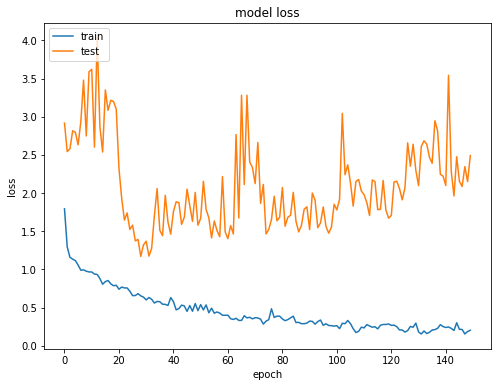

In [ ]:
#plot history
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

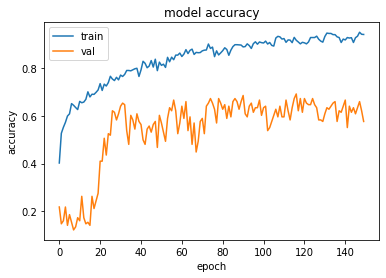

In [ ]:
# Accuracy plot
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Load all models
import keras
model_path = '/content/drive/MyDrive/audd saved files/gujrati dataset/models'

mp_model = keras.models.load_model(model_path+"/mel_spectrogram_.h5")
mfcc_model = keras.models.load_model(model_path+"/mfcc_.h5")
zc_model = keras.models.load_model(model_path+"/zero_crossing_rate_.h5")

In [ ]:
# Model Ensembling
from keras.models import Model
from keras import layers

def ensembleModels(models, model_input):
    # collect outputs of models in a list
    model_outputs=[model(model_input) for model in models] 
    # averaging outputs
    ensemble_output=layers.average(model_outputs) 
    # build model from same input and avg output
    modelEns = Model(inputs=model_input, outputs=ensemble_output,    name='ensemble')  
   
    return modelEns

In [ ]:
# Ensembling
from keras.models import Input
models=[mp_model,mfcc_model,zc_model]

model_input = Input(shape=models[0].input_shape[1:]) # c*h*w
modelEns = ensembleModels(models, model_input)
modelEns.summary()

modelEns.save(model_path+"/ensemble_.h5")

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 10)           175242      ['input_2[0][0]']                
                                                                                                  
 sequential_5 (Sequential)      (None, 10)           175242      ['input_2[0][0]']                
                                                                                                  
 sequential_3 (Sequential)      (None, 10)           175242      ['input_2[0][0]']                
                                                                                           

In [ ]:
# Load model and evaluate
models_path = '/content/drive/MyDrive/audd saved files/gujrati dataset/models'
model = keras.models.load_model(models_path+"/ensemble_.h5")
model.summary()

print("Test Accuracy is ", model.evaluate(x_test,test_y)[1])


Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 10)           175242      ['input_2[0][0]']                
                                                                                                  
 sequential_5 (Sequential)      (None, 10)           175242      ['input_2[0][0]']                
                                                                                                  
 sequential_3 (Sequential)      (None, 10)           175242      ['input_2[0][0]']                
                                                                                           

RuntimeError: ignored

In [ ]:
from sklearn.preprocessing import LabelBinarizer

def evaluateAll(model, x_test, test_y):
  label_as_binary = LabelBinarizer()
  test_y = label_as_binary.fit_transform(test_y)
  return model.evaluate(x_test,test_y)



In [ ]:
#Test data
import keras
files_path = '/content/drive/MyDrive/audd saved files/gujrati dataset'

x_test = np.load(files_path+"/x_mel_spectrogram_test.npy",allow_pickle=True) 
y_test = np.load(files_path+"/y_mel_spectrogram_test.npy",allow_pickle=True)

# model
model_path = '/content/drive/MyDrive/audd saved files/gujrati dataset/models'

mp_model = keras.models.load_model(model_path+"/mel_spectrogram_.h5")

model_result = evaluateAll(mp_model, x_test, y_test)
print(model_result)
print("model history ", mp_model.history)

13/13 [==============================] - 0s 12ms/step - loss: 0.2081 - accuracy: 0.9536
[0.20806215703487396, 0.9536082744598389]
model history  <keras.callbacks.History object at 0x7f1796f2c7d0>
